## **Set up Environment**

In [1]:
#install aimodelshare library
%%capture
! pip install aimodelshare --upgrade

In [2]:
# Download and unpack data
%%capture
!pip install --upgrade --no-cache-dir gdown
!gdown --id '1-Ku-fu1X9pge26ZMji_yCKQqWDWbajCV' -O "COVID-19_Radiography_Database.zip"
!unzip COVID-19_Radiography_Database.zip 

In [3]:
# Load libraries and then download data

import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile

from skimage.transform import resize
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3


In [4]:
# Extracting all filenames iteratively
base_path = 'COVID-19 Radiography Database'
categories = ['COVID', 'NORMAL', 'Viral Pneumonia']

# load file names to fnames list object
fnames = []
for category in categories:
    image_folder = os.path.join(base_path, category)
    file_names = os.listdir(image_folder)
    full_path = [os.path.join(image_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

print('number of images for each category:', [len(f) for f in fnames])
print(fnames[0:2]) #examples of file names

number of images for each category: [1200, 1341, 1345]
[['COVID-19 Radiography Database/COVID/COVID (60).png', 'COVID-19 Radiography Database/COVID/COVID (98).png', 'COVID-19 Radiography Database/COVID/COVID (371).png', 'COVID-19 Radiography Database/COVID/COVID (380).png', 'COVID-19 Radiography Database/COVID/COVID (561).png', 'COVID-19 Radiography Database/COVID/COVID (140).png', 'COVID-19 Radiography Database/COVID/COVID (1194).png', 'COVID-19 Radiography Database/COVID/COVID (787).png', 'COVID-19 Radiography Database/COVID/COVID (195).png', 'COVID-19 Radiography Database/COVID/COVID (1154).png', 'COVID-19 Radiography Database/COVID/COVID (799).png', 'COVID-19 Radiography Database/COVID/COVID (766).png', 'COVID-19 Radiography Database/COVID/COVID (530).png', 'COVID-19 Radiography Database/COVID/COVID (224).png', 'COVID-19 Radiography Database/COVID/COVID (750).png', 'COVID-19 Radiography Database/COVID/COVID (677).png', 'COVID-19 Radiography Database/COVID/COVID (867).png', 'COVID-1

## **Preprocessor Function & Setup**

### **Write a Preprocessor Function**


> ###   Preprocessor functions are used to preprocess data into the precise data your model requires to generate predictions.  

*  *Preprocessor functions should always be named "preprocessor".*
*  *You can use any Python library in a preprocessor function, but all libraries should be imported inside your preprocessor function.*  
*  *For image prediction models users should minimally include function inputs for an image filepath and values to reshape the image height and width.*  


In [5]:
# Import image, load to array of shape height, width, channels, then min/max transform.
# Write preprocessor that will match up with model's expected input shape.
# Uses opencv for image preprocessing

def preprocessor(data, shape=(192, 192)):
        """
        This function reads in images, resizes them to a fixed shape, and
        min/max transforms them, before converting feature values to float32
        for ONNX.
        
        params:
            data
                list of unprocessed images
                      
        returns:
            X
                numpy array of preprocessed image data
                  
        """
           
        import cv2
        import numpy as np

        "Resize a color image and min/max transform the image"
        img = cv2.imread(data) # Read in image from filepath.
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # cv2 reads in images in order of blue green and red, we reverse the order for ML.
        #grayscale image?  Use im_gray = cv2.imread('gray_image.png', cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, shape) # Change height and width of image.
        img = img / 255.0 # Min-max transform.  

        # Resize the images.
        X = np.array(img)
        #X = np.expand_dims(X, axis=0) # Expand dims to add "1" to object shape [1, h, w, channels] if needed.
        X = np.array(X, dtype=np.float32) # Final shape for onnx runtime.
        return X

#Try on single flower file (imports file and preprocesses it to data with following shape)
#preprocessor('COVID-19 Radiography Database/COVID/COVID (1).png').shape

In [6]:
#Import image files iteratively and preprocess them into array of correctly structured data

# Create list of file paths
image_filepaths=fnames[0]+fnames[1]+fnames[2]

# Iteratively import and preprocess data using map function

# map functions apply your preprocessor function one step at a time to each filepath
preprocessed_image_data=list(map(preprocessor,image_filepaths ))

# Object needs to be an array rather than a list for Keras (map returns to list object)
X= np.array(preprocessed_image_data) # Assigning to X to highlight that this represents feature input data for our model

In [7]:
len(image_filepaths)

3886

In [8]:
print(len(X) ) #same number of elements as filenames
print(X.shape ) #dimensions now 192,192,3 for all images
print(X.min() ) #min value of every image is zero
print(X.max() ) #max value of every image is one


3886
(3886, 192, 192, 3)
0.0
1.0


In [9]:
# Create y data made up of correctly ordered labels from file folders
from itertools import repeat

# Recall that we have five folders with the following number of images in each folder 
#...corresponding to each flower type

print('number of images for each category:', [len(f) for f in fnames])
covid=list(repeat("COVID", 1200))
normal=list(repeat("NORMAL", 1341))
pneumonia=list(repeat("PNEUMONIA", 1345))

#combine into single list of y labels
y_labels = covid+normal+pneumonia

#check length, same as X above
print(len(y_labels) )

# Need to one hot encode for Keras.  Let's use Pandas

import pandas as pd
y=pd.get_dummies(y_labels)

display(y)

number of images for each category: [1200, 1341, 1345]
3886


,COVID,NORMAL,PNEUMONIA
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
3881,0,0,1
3882,0,0,1
3883,0,0,1
3884,0,0,1


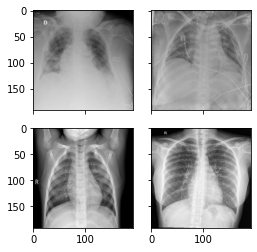

In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import random

im1 =preprocessor('COVID-19 Radiography Database/COVID/COVID (100).png')
im2 =preprocessor('COVID-19 Radiography Database/COVID/COVID (1024).png')
im3 =preprocessor('COVID-19 Radiography Database/NORMAL/NORMAL (1000).png')
im4 =preprocessor('COVID-19 Radiography Database/NORMAL/NORMAL (1031).png')

fig = plt.figure(figsize=(4., 4.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.25,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [im1, im2, im3, im4]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
plt.show()

In [11]:
# ======Train test split resized images (Hackathon Note!! Use same train test split to be able to submit predictions to leaderboard!)=======================================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.20, random_state = 1987)


y_test.sum()

COVID        240
NORMAL       269
PNEUMONIA    269
dtype: int64

## **Save Preprocessor**
### Saves preprocessor function to "preprocessor.zip" file

In [12]:
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"") 

Your preprocessor is now saved to 'preprocessor.zip'


## **Submit Models**

In [13]:
#Instantiate Competition 
mycompetition= ai.Competition("https://79ei37u6vf.execute-api.us-east-1.amazonaws.com/prod/m")


In [14]:
#Authorized users can submit new models after setting credentials using modelshare.org username/password

apiurl="https://79ei37u6vf.execute-api.us-east-1.amazonaws.com/prod/m" # example url from deployed playground: apiurl= "https://123456.execute-api.us-east-1.amazonaws.com/prod/m

import aimodelshare
aimodelshare.aws.set_credentials(apiurl=apiurl)

AI Modelshare Username:··········
AI Modelshare Password:··········
AI Model Share login credentials set successfully.


In [ ]:
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=64, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=128, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=128, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    # classifying into 3 categories
    tf.keras.layers.Dense(3, activation='softmax')
  ])
  #from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  #red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs

  model.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  # Fitting the CNN to the Training set
  model.fit(X_train, y_train, 
                    epochs = 1, verbose=1,validation_data=(X_test,y_test)) #, callbacks=[red_lr]) for callback that automatically adjusts lr

98/98 [==============================] - 511s 5s/step - loss: 0.4841 - accuracy: 0.8005 - val_loss: 0.2337 - val_accuracy: 0.9139


In [ ]:
# Save Model to .onnx file
from aimodelshare.aimsonnx import model_to_onnx

# Save tf.keras model to ONNX file
onnx_model = model_to_onnx(model, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

# Save model to local .onnx file
with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString()) 

In [ ]:
# using predict_classes() for multi-class data to return predicted class index.

def predict_classes(x): # adjusted from keras github code
  proba=x
  if proba.shape[-1] > 1:
      return proba.argmax(axis=-1)
  else:
      return (proba > 0.5).astype("int32")

print(predict_classes(model.predict(X_test)))

prediction_index=predict_classes(model.predict(X_test))

#Now lets run some code to get keras to return the label rather than the index...

# get labels from one hot encoded y_train data
labels=pd.get_dummies(y_train).columns

# Iterate through all predicted indices using map method
prediction_labels=list(map(lambda x: labels[x], prediction_index))

[2 1 0 2 2 0 2 0 1 2 2 1 0 2 0 2 0 1 2 2 2 2 1 0 2 2 2 1 1 2 1 2 1 1 2 0 2
 2 0 2 2 0 1 0 1 1 0 0 2 2 2 0 2 1 1 1 1 0 1 2 1 0 0 1 1 1 2 1 2 1 1 2 0 2
 1 1 1 1 0 2 0 1 2 1 0 2 1 2 0 1 1 1 2 2 0 2 0 1 2 2 1 0 0 0 2 1 0 2 0 0 0
 0 0 2 2 2 2 2 2 2 1 0 2 1 0 2 0 2 0 1 1 2 1 0 0 0 2 0 1 0 0 1 1 2 1 0 0 0
 1 1 0 1 1 1 2 1 0 0 2 1 2 0 0 0 2 2 1 0 0 0 1 1 1 2 0 0 0 2 0 2 2 2 1 1 0
 2 0 1 1 1 2 1 2 2 1 1 2 1 2 2 0 1 0 1 0 2 0 0 1 1 1 1 0 0 1 1 1 1 0 2 2 0
 2 2 2 2 2 1 2 1 0 2 0 1 1 1 1 1 0 2 1 1 0 2 2 0 2 0 2 2 0 2 1 0 2 2 2 0 2
 0 1 0 1 2 2 1 2 1 1 1 0 2 0 1 2 1 1 2 2 1 1 0 2 2 0 0 0 1 0 2 2 1 0 2 0 2
 2 0 1 0 0 1 2 2 1 2 0 2 1 2 0 1 2 2 1 0 1 2 0 2 1 2 1 0 2 1 2 2 1 1 0 1 0
 1 0 1 2 1 0 2 2 0 0 2 0 2 0 2 1 2 0 2 2 0 1 0 2 2 2 0 0 0 1 0 1 0 0 2 1 0
 0 2 0 2 1 1 2 1 2 0 2 2 1 2 0 1 1 2 0 0 2 0 2 1 1 2 2 0 0 2 2 2 0 1 0 0 2
 2 2 2 0 1 1 2 0 2 2 2 1 0 0 0 0 1 2 2 1 1 1 1 0 2 1 1 2 1 2 0 2 2 0 2 2 2
 2 0 0 0 0 2 1 2 2 2 2 2 1 2 1 0 1 2 2 2 1 2 2 2 0 1 0 2 0 1 2 0 2 0 1 2 0
 1 1 1 1 1 0 1 0 2 1 0 2 

In [ ]:
# Submit Model 1 to Competition Leaderboard
mycompetition.submit_model(model_filepath = "model.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 71

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:1539


Get Leaderboard

In [ ]:
data = mycompetition.get_leaderboard()
mycompetition.stylize_leaderboard(data)

,accuracy,f1_score,precision,recall,ml_framework,transfer_learning,deep_learning,model_type,depth,num_params,dense_layers,flatten_layers,conv2d_layers,maxpooling2d_layers,relu_act,softmax_act,loss,optimizer,model_config,memory_size,username,version
0,97.69%,97.74%,97.76%,97.74%,keras,False,True,Sequential,7,977987,1,1,3.000000,2,3,1,str,Adam,"{'name': 'sequential_1', 'laye...",1621536,cz2673,5
1,97.56%,97.58%,97.59%,97.60%,keras,False,True,Sequential,7,977987,1,1,3.000000,2,3,1,str,Adam,"{'name': 'sequential_16', 'lay...",1625648,cz2673,4
2,94.86%,94.86%,94.83%,94.92%,keras,False,True,Sequential,7,977987,1,1,3.000000,2,3,1,str,Adam,"{'name': 'sequential_12', 'lay...",1623728,cz2673,3
3,92.93%,92.94%,92.92%,92.99%,keras,False,True,Sequential,13,1852707,1,1,8.000000,3,8,1,str,Adam,"{'name': 'sequential', 'layers...",2347056,hp2500test,2
4,90.75%,90.76%,91.32%,90.61%,keras,False,True,Sequential,13,1852707,1,1,nan,3,8,1,str,Adam,"{'name': 'sequential', 'layers...",2346288,nikkigsak,7
5,88.43%,88.56%,89.16%,88.32%,keras,False,True,Sequential,13,1852707,1,1,nan,3,8,1,str,Adam,"{'name': 'sequential', 'layers...",2346288,nikkigsak,6
6,88.05%,88.26%,90.00%,88.01%,keras,False,True,Sequential,16,3811619,1,1,10.000000,4,10,1,str,Adam,"{'name': 'sequential', 'layers...",2632440,AdvProjectsinML,1


Compare Models

In [ ]:
# Compare two or more models (Experimental, Git-like Diffs for Model Architectures)
data=mycompetition.compare_models([1,2], verbose=1)
mycompetition.stylize_compare(data)

,Model_1_Layer,Model_1_Shape,Model_1_Params,Model_2_Layer,Model_2_Shape,Model_2_Params
0,Conv2D,"[None, 192, 192, 32]",896,Conv2D,"[None, 192, 192, 32]",896.000000
1,Conv2D,"[None, 192, 192, 32]",1056,Conv2D,"[None, 192, 192, 32]",1056.000000
2,MaxPooling2D,"[None, 96, 96, 32]",0,MaxPooling2D,"[None, 96, 96, 32]",0.000000
3,Conv2D,"[None, 96, 96, 64]",18496,Conv2D,"[None, 96, 96, 64]",18496.000000
4,Conv2D,"[None, 96, 96, 64]",4160,Conv2D,"[None, 96, 96, 64]",4160.000000
5,MaxPooling2D,"[None, 48, 48, 64]",0,MaxPooling2D,"[None, 48, 48, 64]",0.000000
6,Conv2D,"[None, 48, 48, 128]",73856,Conv2D,"[None, 48, 48, 128]",73856.000000
7,Conv2D,"[None, 48, 48, 128]",16512,Conv2D,"[None, 48, 48, 128]",16512.000000
8,MaxPooling2D,"[None, 24, 24, 128]",0,MaxPooling2D,"[None, 24, 24, 128]",0.000000
9,Conv2D,"[None, 24, 24, 512]",590336,Conv2D,"[None, 24, 24, 512]",590336.000000


#### Check structure of y test data 
(This helps users understand how to submit predicted values to leaderboard)

In [ ]:
mycompetition.inspect_y_test()

{'class_balance': {'COVID': 240, 'NORMAL': 269, 'PNEUMONIA': 269},
 'class_labels': ['PNEUMONIA', 'NORMAL', 'COVID'],
 'label_dtypes': {"<class 'str'>": 778},
 'y_length': 778,
 'ytest_example': ['PNEUMONIA', 'NORMAL', 'COVID', 'NORMAL', 'PNEUMONIA']}

## Homework 

### Citation of paper providing original dataset:
M.E.H. Chowdhury, T. Rahman, A. Khandakar, R. Mazhar, M.A. Kadir, Z.B. Mahbub, K.R. Islam, M.S. Khan, A. Iqbal, N. Al-Emadi, M.B.I. Reaz, “Can AI help in screening Viral and COVID-19 pneumonia?” arXiv preprint, 29 March 2020, https://arxiv.org/abs/2003.13145

### 1. Visualize images that demonstrate when x-rays demonstrate Covid Postivity and when they do not (You can present visuals of each category in the data if you would like to).


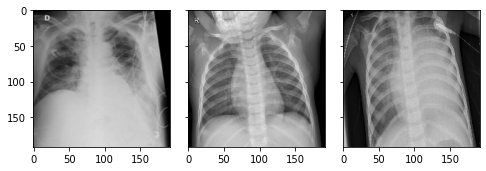

In [ ]:
im1 =preprocessor('COVID-19 Radiography Database/COVID/COVID (291).png')
im2 =preprocessor('COVID-19 Radiography Database/NORMAL/NORMAL (70).png')
im3 =preprocessor('COVID-19 Radiography Database/Viral Pneumonia/Viral Pneumonia (303).png')

fig = plt.figure(figsize=(8., 8.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 3),  # creates 2x2 grid of axes
                 axes_pad=0.25,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [im1, im2, im3]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
plt.show()

X-ray images that depict Covid Positivity show blurriness/fuzziness in the lung area of the subject. A normal lung X-ray not affected by Covid is a much clearer image. Above, the first image shows an individual that is afflicted by Covid. The second image is a healthy/normal individual and the last image shows an individual with Viral Pneumonia. We can see that the individual infected with Covid has the cloudiest image representing larger damage to the lungs than Pneumonia. 

### 2. Discuss the dataset in general terms and describe why building a predictive model using this data might be practically useful. Who could benefit from a model like this? Explain.


This dataset is public database that includes a collection of images of lung scans (specifically COVID-19 chest x-ray images) from published articles. Building a predictive model using this data is practically useful for a number of reasons. Firstly, x-ray images of viral pneumonia to the human eye can be similar to x-ray images of COVID-19 positive lungs. However, convulutional neural networks is able to extract distinct features from these images and train/learn from the known data to avoid misdiagnosis. It also has the ability to analyze and perform using larger datasets, which is beneficial for a large scale extraction during something as big as a pandemic with an overwhelming amount of unprecedented information. A readily available database helps stimulate/catalyze research surrounding COVID-19 during a dire time where researchers may not have access to the necessary information. Additionally, rapid and PCR tests were scarce, and still are in some developing countries. Having multiple ways to detect COVID-19 positivity is beneficial for not only learning more about the virus itself, but to offer multiple avenues to test for COVID-19.

###3. Run at least three prediction models to try to predict x-ray images well. Use transfer learning for at least one of these models



#### Model: Convolutional Neural Network

In [ ]:
with tf.device('/device:GPU:0'): 

  model = tf.keras.Sequential([   
    tf.keras.layers.Conv2D(kernel_size=5, filters=32, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=5, filters=64, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=64, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=5, filters=128, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=128, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=5, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(3, activation='softmax')
  ])

  model.compile(
    optimizer="adam", 
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  # Fitting the CNN to the Training set
  model.fit(X_train, y_train, 
                    epochs = 1, verbose=1,validation_data=(X_test,y_test))

98/98 [==============================] - 1015s 10s/step - loss: 0.5715 - accuracy: 0.7471 - val_loss: 0.6796 - val_accuracy: 0.7481


In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_306 (Conv2D)         (None, 192, 192, 32)      2432      
                                                                 
 conv2d_307 (Conv2D)         (None, 192, 192, 32)      1056      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 96, 96, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_308 (Conv2D)         (None, 96, 96, 64)        51264     
                                                                 
 conv2d_309 (Conv2D)         (None, 96, 96, 64)        4160      
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 48, 48, 64)       0         
 g2D)                                                 

Accuracy: .7471
Val Accuracy: .7481

#### Model: VGG19

In [ ]:
with tf.device('/device:GPU:0'): # "/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
                                 
        keras_model = Sequential()
        keras_model.add(Conv2D(filters = 96, kernel_size = (11,11), strides = (4,4), padding = 'same', activation='relu', input_shape=[192, 192, 3]))
        keras_model.add(BatchNormalization())
        keras_model.add(MaxPooling2D(pool_size= (3,3), strides = (2,2)))
        keras_model.add(Conv2D(filters= 256, kernel_size= (5,5), strides = (1,1), padding='same', activation='relu'))
        keras_model.add(BatchNormalization())
        keras_model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
        keras_model.add(Conv2D(filters= 384, kernel_size= (3,3), strides = (1,1), padding='same', activation='relu'))
        keras_model.add(BatchNormalization())
        keras_model.add(Conv2D(filters= 384, kernel_size= (3,3), strides = (1,1), padding='same', activation='relu'))
        keras_model.add(BatchNormalization())
        keras_model.add(Conv2D(filters= 256, kernel_size= (3,3), strides = (1,1), padding='same', activation='relu'))
        keras_model.add(BatchNormalization())
        keras_model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
        keras_model.add(Flatten())
        keras_model.add(Dense(124, activation='relu'))
        keras_model.add(Dropout(0.5))
        keras_model.add(Dense(124, activation='relu'))
        keras_model.add(Dropout(0.5))
        keras_model.add(Dense(3, activation='softmax'))

        # Compile model...
        keras_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

        # Fitting the NN to the Training set...
        hist = keras_model.fit(X_train, y_train,
                          epochs=1, verbose=1, validation_data=(X_test, y_test))

98/98 [==============================] - 364s 4s/step - loss: 1.8146 - accuracy: 0.5502 - val_loss: 29.9906 - val_accuracy: 0.3201


In [ ]:
keras_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 module_wrapper (ModuleWrapp  (None, 48, 48, 96)       34944     
 er)                                                             
                                                                 
 batch_normalization_282 (Ba  (None, 48, 48, 96)       384       
 tchNormalization)                                               
                                                                 
 module_wrapper_1 (ModuleWra  (None, 23, 23, 96)       0         
 pper)                                                           
                                                                 
 module_wrapper_2 (ModuleWra  (None, 23, 23, 256)      614656    
 pper)                                                           
                                                                 
 batch_normalization_283 (Ba  (None, 23, 23, 256)     

 Accuracy: 0.5502 Val Accuracy: 0.3201

#### Model: VGG16

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras import backend as K

base_model = VGG16(input_shape=(192,192,3),
                                               include_top=False, # Drops fully connected layers and output layer structure from pretrained model.
                                               weights='imagenet') # Using weight from model trained to 1000 categories of imagenet competition
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 192, 192, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 192, 192, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 96, 96, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 96, 96, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 96, 96, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 48, 48, 128)       0     

In [ ]:
IMG_SHAPE = (192, 192, 3)
conv_base = InceptionV3(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
freeze_layers_after=10
for layer in conv_base.layers[freeze_layers_after:]:
  layer.trainable =  False

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

      vgg_model = Sequential()
      vgg_model.add(conv_base)
      vgg_model.add(GlobalAveragePooling2D())
      vgg_model.add(Dense(120, activation='relu'))
      vgg_model.add(Dropout(0.2))
      vgg_model.add(Dense(60, activation='relu'))
      vgg_model.add(Dense(30, activation='relu'))
      vgg_model.add(Flatten())
      vgg_model.add(Dense(3, activation='softmax')) 

      vgg_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 
      vgg_model.fit(X_train, y_train,
          epochs = 3 , verbose=1,validation_data=(X_test,y_test))

Epoch 1/3
98/98 [==============================] - 902s 9s/step - loss: 0.3977 - acc: 0.8346 - val_loss: 0.5168 - val_acc: 0.8213
Epoch 2/3
98/98 [==============================] - 871s 9s/step - loss: 0.2000 - acc: 0.9353 - val_loss: 0.3740 - val_acc: 0.8689
Epoch 3/3
98/98 [==============================] - 866s 9s/step - loss: 0.1688 - acc: 0.9418 - val_loss: 0.3664 - val_acc: 0.8599


In [ ]:
## summarize
vgg_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_10 (Dense)            (None, 120)               245880    
                                                                 
 dropout_2 (Dropout)         (None, 120)               0         
                                                                 
 dense_11 (Dense)            (None, 60)                7260      
                                                                 
 dense_12 (Dense)            (None, 30)                1830      
                                                      

Accuracy: .9418 Val Accuracy: .8599

###4. Discuss which models performed better and point out relevant hyper-parameter values for successful models.

Out of all of the models I ran, the best peforming model for me was the VGG16. It is a sequential model using the keras framework. This model achieved a val accuracy of .8599 which was higher than the VGG19 and CNN models. Firstly, for the VGG16 model, I decided to change the number of epochs to 3. The reason I originally chose 1 for the other models was because how long it took to run the models with more than 1 epoch. VGG16 with 3 epochs took me approximately 50 minutes to run. The amount of epochs indicates how many times the algorithm is training on the whole dataset. The number of iterations are the number of batches required to complete each epoch. Although increasing the epoch does seem to improve the val accuracy of the model, using too many epochs may cause your model to over-fit the training data. The batch size for each epoch in this model is 98. To speed up the training speed, I also set trainable = False to freeze after layer 10. I also include a dropout layer (0.2) so remove some of the nodes so that the neural network is not too heavy when running the model. 




###5. Submit your best model to the leader board for the COVID Image Classification Hackathon competition.

In [ ]:
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"") 

Your preprocessor is now saved to 'preprocessor.zip'


In [ ]:
#Instantiate Competition 
mycompetition= ai.Competition("https://79ei37u6vf.execute-api.us-east-1.amazonaws.com/prod/m")

In [ ]:
#Authorized users can submit new models after setting credentials using modelshare.org username/password

apiurl="https://79ei37u6vf.execute-api.us-east-1.amazonaws.com/prod/m" # example url from deployed playground: apiurl= "https://123456.execute-api.us-east-1.amazonaws.com/prod/m

import aimodelshare
aimodelshare.aws.set_credentials(apiurl=apiurl)

AI Modelshare Username:··········
AI Modelshare Password:··········
AI Model Share login credentials set successfully.


In [ ]:
# Save Model to .onnx file
from aimodelshare.aimsonnx import model_to_onnx

# Save tf.keras model to ONNX file
onnx_model = model_to_onnx(vgg_model, framework='keras',
                          transfer_learning=True,
                          deep_learning=True)

# Save model to local .onnx file
with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString()) 

In [ ]:
# using predict_classes() for multi-class data to return predicted class index.

def predict_classes(x): # adjusted from keras github code
  proba=x
  if proba.shape[-1] > 1:
      return proba.argmax(axis=-1)
  else:
      return (proba > 0.5).astype("int32")

print(predict_classes(vgg_model.predict(X_test)))

prediction_index=predict_classes(vgg_model.predict(X_test))

#Now lets run some code to get keras to return the label rather than the index...

# get labels from one hot encoded y_train data
labels=pd.get_dummies(y_train).columns

# Iterate through all predicted indices using map method
prediction_labels=list(map(lambda x: labels[x], prediction_index))

[1 1 0 1 2 0 1 0 1 0 1 1 0 2 0 0 0 2 1 2 2 2 1 0 2 0 1 2 1 2 2 0 1 1 0 0 0
 1 0 2 0 0 2 0 1 1 0 0 2 1 2 0 2 1 1 1 1 0 1 1 1 0 0 1 1 1 2 1 2 1 1 2 0 0
 1 1 1 1 0 1 0 1 2 1 0 0 1 0 0 1 1 1 2 2 0 0 0 1 2 0 1 0 0 1 2 2 0 0 0 0 0
 0 0 2 2 2 0 2 1 2 1 1 2 1 0 2 0 0 0 1 1 2 1 0 0 0 2 0 1 0 0 1 2 2 1 0 0 0
 1 1 2 1 1 1 0 1 0 0 2 1 2 0 0 0 2 2 1 0 0 0 2 1 1 0 0 0 0 2 0 2 2 0 1 1 0
 2 0 2 1 1 1 0 0 2 1 1 1 1 1 2 0 2 0 1 0 1 0 2 1 1 1 2 0 0 1 0 1 1 2 2 2 0
 2 2 2 0 2 1 2 1 1 1 0 1 1 1 1 1 0 1 1 1 0 2 2 0 2 0 1 1 0 2 1 0 0 2 2 0 2
 0 2 0 1 0 1 1 1 1 1 1 0 0 0 2 2 2 1 2 0 0 1 0 0 2 0 0 0 0 0 2 0 1 0 2 1 2
 0 0 1 0 0 1 2 2 1 2 0 0 1 0 0 1 2 0 1 0 1 2 0 2 1 2 1 0 2 1 2 2 1 1 0 1 0
 1 0 2 2 1 0 2 2 0 0 2 0 2 0 0 2 2 0 1 2 0 1 0 2 2 1 0 0 0 1 0 1 0 0 0 1 0
 0 1 0 2 1 2 2 1 2 0 1 1 1 0 0 2 1 0 0 0 2 0 2 1 1 1 2 0 0 2 2 2 0 1 0 0 2
 2 0 2 0 1 1 2 0 2 2 0 1 0 0 0 0 1 1 1 1 1 1 1 0 0 1 1 2 1 0 0 2 2 0 2 2 2
 1 0 0 0 0 2 1 1 0 2 2 2 1 2 1 2 1 1 1 0 1 2 0 2 0 1 0 2 0 2 2 0 2 0 1 2 2
 1 1 1 1 1 0 1 0 0 1 0 2 

In [ ]:
# Submit Best Model to Competition Leaderboard
mycompetition.submit_model(model_filepath = "model.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

Insert search tags to help users find your model (optional): vgg16
Provide any useful notes about your model (optional): vgg16

Your model has been submitted as model version 129

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:1539


Submitted best model: VGG16 (model 129)

###6.  Import the best model from the leader board (whatever the best model is after your final submission) 
Note:
* Use the aimodelshare instantiate_model() function
* Visualize the model's structure using tf.keras model.summary()
* Explain how the model's structure is different from your best model.
* Explain how the model's optimization approach is different from your best model
* Fit the best model from the leader board to training data and evaluate it on test data to complete your report.

In [19]:
#Instantiate Competition 
mycompetition= ai.Competition("https://79ei37u6vf.execute-api.us-east-1.amazonaws.com/prod/m")
best_model = mycompetition.instantiate_model(100) ## could not load other best models so went with version 100
best_model.summary()

Instantiate the model from metadata..
Your model is successfully instantiated.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 192, 192, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 192, 192, 32)      1056      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 96, 96, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 96, 96, 64)        4160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48

The best model I pulled has a depth of 13 layers while mine has a depth of 7. They both use a keras framework and are deep learning models. However, the best model does not use transfer learning while my VGG16 model does. The best model uses 1,852,707 trainable paramters while mine only uses 255,063. 

Both of the models use the same optimizer approach, Adam. This optimizer is typically faster to converge and has a faster computation time in comparison to SGD. It also requires fewer paramters for tuning.

In [27]:
best_model.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])

best_model.fit(X_train, y_train, 
                    epochs = 1, verbose=1,validation_data=(X_test,y_test))

98/98 [==============================] - 516s 5s/step - loss: 0.4805 - accuracy: 0.7960 - val_loss: 0.2323 - val_accuracy: 0.9100


Val accuracy: .9100